# calculate (Basset) History term
In this  notebook the (basset) history force is calculated given by: 
$$ \mathbf{F}_{history}  = 3\pi \nu_f d \int_{0}^t K(t-s)\frac{d}{ds} (\mathbf{u}_p(s) -\mathbf{u}_s(s)) ds $$ 
with the ``Kernel'' K depends on the particle Reynolds number, for small Reynolds number we have the Basset version:
$$ K_{Basset} = \frac{d}{2 \pi \sqrt{t-s}}$$
For larger particle Reynolds number different the history kernel of Mei1992 is used 
$$ \mathbf{F}_{history}  = 3\pi \nu_f d \int_{0}^t K(t-s)\frac{d}{ds} (\mathbf{u}_p(s) -\mathbf{u}_s(s)) ds $$ 
where there are slightly differnt values for coefficients c1 and c2 from literature:
- Mei 1992 : c1 = 2, c2 = 0.1015
- Kim 1996 : c1 = 2.5 c2 = 0.126
- Dorgan 2007: c1 = 2.5, c2 = 0.2
For larger Reynolds numbers there is a crossover between basset like decay (as ^0.5) at short time scales and squared  
decay (^2) on long timescales. The timescale associated with this is $\tau_h$ and makes that the history decays faster  
to zero for larger particles reynolds numbers, this allows to use a finite window to calculate the history term from  
time $t-\tau_h$ to current time $t$.

In [1]:
# import needed packages

#update reading in packages when rerunning this cell
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import cartopy.crs as ccrs #for plotting on map
import cartopy as cart
import scipy.special as sc
from datetime import datetime, timedelta
import sys
sys.path.append("/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/simulations")
plt.style.use('../python_style_Meike.mplstyle')



In [ ]:
# needed functions
def stokes_relaxation_time(d, viscosity_water, B):
    return (1 + 2 * B) * d * d / (36 * viscosity_water)
 
def Basset_kernel(t,s,d, nu):
    tau_diff = d * d / nu
    return (tau_diff / (4 * np.pi * (t-s)))**(0.5)

def Mei1992_kernel(t,s,c1,c2,d, nu, Rep):
    tau_diff = d * d / nu
    term1 = (4 * np.pi * (t-s) /tau_diff)**(1./(2 * c1))
    fh = (0.75 + c2 * Rep)**3
    term2 =  (Rep**3 * np.pi * (t-s)**2 / (fh * tau_diff**2) )**(1./c1) 
    return (term1+term2)**(-c1)

def dUslip_dt(uslip,dt):
        umin=uslip.shift(obs=-1)
        umax=uslip.shift(obs=1)
        return (uslip-umin)/(1 * dt)

def REp(uslip,vslip, d, nu):
    return np.sqrt(uslip**2 + vslip**2) * d / nu

def factor_drag(Uslip,L,nu):
    Rep=np.abs(Uslip) * L / nu
    f_REp = 1 + Rep / (4. * (1 +  np.sqrt(Rep))) + Rep / 60.
    return f_REp

def diffusion_timescale(d, nu):
    """
    Diffusion timescale of particle depends on 
    - d diameter particle (in m)
    - nu kinematic viscosity fluid in which particle is embedded (m^2/s)
    """
    return d * d / nu

def history_timescale(Rep, tau_diff):
    """"
    History timescale for Mei1992 history term with
    Dorgan2007 coeffients, sets timescale for time window
    needed when caluculate history term and depents on
    - tau_diff diffusion timescale particle (1/s)
    - Rep Particle Reynolds number
    """
    return tau_diff * (0.502/Rep + 0.123)**2
     


In [ ]:
# function to numerically calculate history term    
## think whther you want to order f in order t0 -> t or t -> t0 (now I assume it is ordered as t0 -> tt-> t0 (so f[0] is f at t-N*h, and f[N] is f at t))

def factor_drag_white1991(Rep):
    """
    stokes drag corection factor valid up to Rep < 10^5 from
    [1] F. M. White, Viscous fluid flow 2nd edition (1991)(p. 182)
    """
    c_REp = 1 + Rep / (4. * (1 +  np.sqrt(Rep))) + Rep / 60.
    return c_REp

def Hinsberg(f, N, h):
    """
    Calculate history term using the expression proposed by Hinsberg 2011
    with N total number of segments
    h timestep
    f array of N elements (given by slip velocity or slip + part of Mei kernel)
    note f has length N+1 k in [0,N]
    """
    K0 = 4/3  * f[N] * np.sqrt(h)
    KN = f[0] * np.sqrt(h) * (N-4/3) / ((N-1)*np.sqrt(N - 1) +(N-3/2) * np.sqrt(N))
    KSUM = np.sum([np.sqrt(h) * f[N-k] * ( (k + 4/3) / ((k + 1)**(3/2) + (k + 3/2) * np.sqrt(k)) + (k - 4/3) /((k - 1)**(3/2) + (k - 3/2) * np.sqrt(k))) for k in range(1,N,1)])
    return K0 + KN + KSUM

def Daitche(f, N, h):
    """
    Calculate history term using the expression proposed by Daitche 2013
    with N total number of segments
    h timestep
    f array of N elements (given by slip velocity or slip + part of Mei kernel)
    note f has length N+1 k in [0,N]
    need quadruble (float128) precision for test case
    """
    K0 = (4/3  * np.sqrt(h,dtype = np.float128) * f[N] )
    KN =  4/3 * np.sqrt(h) * ((N - 1) * np.sqrt(N-1,dtype = np.float128) - N*np.sqrt(N,dtype = np.float128) + 6/4 * np.sqrt(N, dtype = np.float128)) * f[0] 
    KSUM = np.sum([4/3 * np.sqrt(h, dtype = np.float128) *((k-1)*np.sqrt(k-1,dtype = np.float128) + (k+1)*np.sqrt(k+1,dtype = np.float128) - 2 * k*np.sqrt(k,dtype = np.float128)) * f[N-k] for k in range(1,N,1)])
    return K0 + KN + KSUM

def f_Mei1992(dudt, t, c1, c2, Rep ,N ,h ,S):
    f_h = 0.75 + c2 * Rep
    f = [ dudt[k] * (1 + (np.sqrt(np.pi * (t -h * k)**3 / (S **3)) * Rep**3 / (2 * (f_h)**3 ))**(1/c1) )**(-c1) for k in range(0,N+1,1)]
    return f

def f_Mei1992_unit(dudt, t, c1, c2, Rep ,N ,h):
    # version where kernel is unitless and only slip velocity hase units, time intergral is in terms of t' =  4 pi t  /tau_diff 
    f_h = 0.75 + c2 * Rep
    f = [ dudt[k] * (1 + ((t -h * k)**(3/2) * Rep**3 / (16 * np.pi * (f_h)**3 ))**(1/c1) )**(-c1) for k in range(0,N+1,1)]
    return f

def History_Force_Hinsberg_Mei_kernel(dudt, t, c1, c2, Rep, N, dt,d,nu, rho):
    tau_diff = d * d / nu #diffusion timescale
    h = dt * 4 * np.pi / tau_diff
    tprime = t * 4 * np.pi / tau_diff
    f =  f_Mei1992_unit(dudt, tprime, c1, c2, Rep, N, h)
    history = tau_diff / (4 * np.pi) * Hinsberg(f,N,h)
    return 3*np.pi * d * nu * rho * history


def History_Force_Hinsberg_Basset_kernel(dudt, t, N, dt,d,nu, rho):
    tau_diff = d * d / nu #diffusion timescale
    h = dt * 4 * np.pi / tau_diff
    history = tau_diff / (4 * np.pi) * Hinsberg(dudt,N,h)
    return 3*np.pi * d * nu * rho * history

def Slip_Force(dudt,d,nu,rho,Rep):
    C_Rep = factor_drag_white1991(Rep)
    return dudt * 3 * np.pi * C_Rep * nu * d * rho 

In [ ]:
def dUslip_dt_cos(t):
    return np.cos(t,dtype = np.float128)
    
def Basset_analytical_cos(t):
    
    S, C = sc.fresnel(np.sqrt(2 * t / np.pi))
    return np.sqrt(2 * np.pi ) * (np.cos(t) * C + np.sin(t) * S )

    
def dUslip_dt_tt(t):
    return t*t
    
def Basset_analytical_tt(t):
    return 2/15 * np.sqrt(t) * 8 * t *t 


In [ ]:
# constants
Rearth = 6371 * 10**3 # in k,
deg2rad = np.pi / 180.
sec_in_min = 60
min_in_hour = 60
sec_in_hour = sec_in_min * min_in_hour


rho_water = 1027 # kg/m3 https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
dynamic_viscosity_water = 1.41 * 10**(-3) # kg/(ms) https://www.engineeringtoolbox.com/sea-water-properties-d_840.html (at 10 deg)
kinematic_viscosity_water = dynamic_viscosity_water / rho_water
diameter =0.2 # m
B=0.68
tau_p = stokes_relaxation_time(diameter, kinematic_viscosity_water, B)
S = 1/12 * diameter* diameter/kinematic_viscosity_water

cs = {'Mei':{'c1':2,'c2':0.105},
             'Kim':{'c1':2.5,'c2':0.126},
             'Dorgan':{'c1':2.5,'c2':0.2}}

## compare numerical solution Basset history term for idealized flow

In [ ]:
Daitche_analytical_tt=[]
Hinsberg_analytical_tt=[]
Daitche_analytical_cos=[]
Hinsberg_analytical_cos=[]


T = 50 * np.pi
Nlist =  np.array([243,729,2187,6561,19683,59049,177411,1594323])
# Nlist =  np.arange(100,100000,100)
for N in Nlist:
    dt = np.float128(T/(N))
    tlist = np.arange(0,T+0.1*dt,dt)
    dudt_tt =dUslip_dt_tt(tlist)
    Daitche_analytical_tt.append(Daitche(dudt_tt,N,dt))
    Hinsberg_analytical_tt.append(Hinsberg(dudt_tt,N,dt))

    dudt_cos =dUslip_dt_cos(tlist)
    Daitche_analytical_cos.append(Daitche(dudt_cos,N,dt))
    Hinsberg_analytical_cos.append(Hinsberg(dudt_cos,N,dt))
analytical_tt =Basset_analytical_tt(T)
analytical_cos =Basset_analytical_cos(T)


 




In [ ]:
fig, ax = plt.subplots()
ax.plot(T/(Nlist), np.abs(Hinsberg_analytical_cos-analytical_cos)/analytical_cos,'--',color='orange')
ax.plot(T/(Nlist), np.abs(Daitche_analytical_cos-analytical_cos)/analytical_cos,'o',color='green')


# ax.plot(T/(Nlist), np.abs(Hinsberg_analytical_tt-analytical_tt)/analytical_tt,'--',color='navy')
# ax.plot(T/(Nlist), np.abs(Daitche_analytical_tt-analytical_tt)/analytical_tt,'o',color='firebrick')

ax.legend(['Hinsberg $\\cos(t)$','Daitche $\\cos(t)$','Hinsberg $t^2$','Daitche $t^2$',])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('dt')

ax.set_ylabel('relative error')
# ax.set_ylim(10**(-14),10**0)
# ax.set_xlim(10**(-4),2*10**(-1))


## Comparing Basset history term and Mei history term for idealized flows

In [ ]:
N = 500
T=50 * np.pi
dt = T/N
c1 = cs['Mei']['c1']
c2 = cs['Mei']['c2']

Rep = 400
S = 1 *  diameter* diameter/kinematic_viscosity_water


tlist = np.arange(0,T+0.1*dt,dt)
dudt_cos =dUslip_dt_cos(tlist)

Nwindow = 50


fmei = f_Mei1992(dudt_cos, T, c1, c2, Rep ,N ,dt ,S)
fmei_window = np.array(fmei)[-(Nwindow + 1):]
fbasset_window = np.array(dudt_cos)[-(Nwindow + 1):]
# fmei_window = [fmei[k] if k > k0 else 0 for k in range(0,N+1,1)]


daitche_Mei = Daitche(fmei,N,dt)
daitche_basset = Daitche(dudt_cos,N,dt)
Hinsberg_Mei = Hinsberg(fmei,N,dt)
Hinsberg_Mei_window = Hinsberg(fmei_window,Nwindow,dt)
Hinsberg_Basset_window = Hinsberg(fbasset_window,Nwindow,dt)

Hinsberg_basset = Hinsberg(dudt_cos,N,dt)
# print(daitche_basset)
# print(daitche_Mei)

print(f'Basset(N={N}) = {Hinsberg_basset} \t Basset(Nwindow ={Nwindow}) = {Hinsberg_Basset_window}')
print(f'Mei (N={N}) = {Hinsberg_Mei} \t Mei(Nwindow ={Nwindow}) = {Hinsberg_Mei_window}')



## checking implementation of history force unitless kernel
Below I compare the implementation of the unitless history kernel (from Dorgan 2007) against the standard version used by Hinsberg/Daitche (checked above) 


In [ ]:
# check force (in Newton!)
T = 50 * np.pi
N = 54564
dt = T/N
Rep = 400
c1 = cs['Mei']['c1']
c2 = cs['Mei']['c2']
S =  diameter* diameter/kinematic_viscosity_water
tlist = np.arange(0,T+0.1*dt,dt)
dudt_cos =dUslip_dt_cos(tlist)

# Nwindow = 50

fmei = f_Mei1992(dudt_cos, T, c1, c2, Rep ,N ,dt ,S)

Hinsberg_unit1 = 3/2 * rho_water *  diameter*diameter* np.sqrt(np.pi * kinematic_viscosity_water) * Hinsberg(fmei,N,dt)
Hinsberg_unit2 =  History_Force_Hinsberg_f_Mei_unit(dudt_cos,T,c1,c2,Rep,N,dt,diameter, kinematic_viscosity_water, rho_water)

print(Hinsberg_unit1)
print(Hinsberg_unit2)


# Calculate history term for simulation data
Also need to check units, goal for now is to write everything in terms of slow manifold MR equation so the history term also has velocity as units (easy to compare with rest of simulation (i.e. can look at uhistory/uflow for example.))

In [ ]:
# need to find correct timescales
Rep=400
tau_diff = diffusion_timescale(diameter,kinematic_viscosity_water) # in sec
print(f'tau_diff = {tau_diff:.2f} s') 
tau_H = history_timescale(Rep,tau_diff) # in sec
print(f'tau_H = {tau_H:.2f} s') #7.5 min



# calculate basset history term for high time resolution data
We use data that ran for 24 h with output every 5 min to calculate
the basset history kernel and term and invastigate its sensitivity
to total timewindow and timesteps used. 

In [ ]:
particle_types = ['inertial','inertial_SM','inertial_drag_Rep','inertial_SM_drag_Rep']
legendnames=['MR Stokes drag','MRSM Stokes drag','MR Re$_p$ drag','MRSM Re$_p$ drag']

In [ ]:
#import short high resolution data


file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_slip_velocity.zarr')

data_24h ={}

#settings
runtime =  timedelta(days=1)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime

chunck_time = 100
nparticles = 88347

for particle_type in particle_types: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis)
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    data_24h[particle_type]=ds
    

In [ ]:


file_base = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_slip_velocity.zarr')

data_month ={}

#settings
runtime =  timedelta(days=30)# timedelta(days=10)
loc = 'NWES'
B = 0.68
tau = 2759.97
coriolis = True
land_handling = 'anti_beaching'
starttime = datetime(2023, 9, 2, 0, 0, 0, 0)
endtime = starttime + runtime

chunck_time = 100
nparticles = 88347

for particle_type in particle_types: 
    file = file_base.format(loc=loc,
                           particle_type = particle_type,
                                                            y_s=starttime.year,
                                                            m_s=starttime.month,
                                                            d_s=starttime.day,
                                                            y_e=endtime.year,
                                                            m_e=endtime.month,
                                                            d_e=endtime.day,
                                                            B = int(B * 1000), 
                                                            tau = int(tau ),
                                                            land_handling = land_handling, 
                                                            cor_on = coriolis)
    ds = xr.open_dataset(file,
                                    engine='zarr',
                                    chunks={'trajectory':nparticles, 'obs':chunck_time},
                                    drop_variables=['B','tau','z'],
                                    decode_times=False) #,decode_cf=False)
    Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
    ds = ds.assign(Uslip = Uslip)
    data_month[particle_type]=ds
    

In [ ]:
for particle_type in particle_types:

    dt = (data_24h[particle_type].time[0,1] -data_24h[particle_type].time[0,0]).values
    print(dt)

    duslipdt = dUslip_dt(data_24h[particle_type].uf,dt)
    dvslipdt = dUslip_dt(data_24h[particle_type].vf,dt)    
    data_24h[particle_type] = data_24h[particle_type].assign(duslipdt = duslipdt)
    data_24h[particle_type] = data_24h[particle_type].assign(dvslipdt = dvslipdt)


In [ ]:
for particle_type in particle_types:

    dt = (data_month[particle_type].time[0,1] -data_month[particle_type].time[0,0]).values
    print(dt)

    duslipdt = dUslip_dt(data_month[particle_type].uf,dt)
    dvslipdt = dUslip_dt(data_month[particle_type].vf,dt)    
    data_month[particle_type] = data_month[particle_type].assign(duslipdt = duslipdt)
    data_month[particle_type] = data_month[particle_type].assign(dvslipdt = dvslipdt)

In [ ]:
particle_type = 'inertial_drag_Rep'
id = 1
fig, ax = plt.subplots()
ax.plot((data_24h[particle_type].time[id,:]-data_24h[particle_type].time[id,0])/sec_in_hour,data_24h[particle_type].uf[id,:],'-',color='orange')
ax2 = ax.twinx()
ax2.plot((data_24h[particle_type].time[id,:]-data_24h[particle_type].time[id,0])/sec_in_hour,data_24h[particle_type].duslipdt[id,:],'--s',color='firebrick')
#very spikey data? 

# particle_type = 'inertial_SM_drag_REp'
# ax.plot(data_24h[particle_type].time[id,5::12]-data_24h[particle_type].time[id,0],data_24h[particle_type].duslipdt[id,5::12])
ax.plot((data_month[particle_type].time[id,:24]-data_month[particle_type].time[id,0])/sec_in_hour,data_month[particle_type].uf[id,0:24],'--',color='green')

ax2.plot((data_month[particle_type].time[id,:24]-data_month[particle_type].time[id,0])/sec_in_hour,data_month[particle_type].duslipdt[id,0:24],':o',color='navy')



In [ ]:
particle_type = 'inertial_drag_REp'
id = 1
fig, ax = plt.subplots()
ax.plot(data_month[particle_type].time[id,:500]-data_month[particle_type].time[id,0],data_month[particle_type].duslipdt[id,:500])
particle_type = 'inertial_SM_drag_REp'
ax.plot(data_month[particle_type].time[id,:500]-data_month[particle_type].time[id,0],data_month[particle_type].duslipdt[id,:500])

In [ ]:
# calculate history force and drag force

id = 1
particle_type = 'inertial_drag_Rep'


ds = data_24h[particle_type].isel(trajectory=id)
dt = (ds.time[1]-ds.time[0]).values
Tend=(ds.time.ffill(dim='obs')[-1]-ds.time[2]).values
N=int(Tend/dt)
print(dt)
print(Tend)
print(N)
# sel = ds.duslipdt.pipe(np.isnan)
print(tau_H/dt)
Nwindowlist = np.arange(5,200,5)
F_H_mei_Nwindow = []
F_H_basset_Nwindow = []
for Nwindow in Nwindowlist:


    F_H_mei = History_Force_Hinsberg_Mei_kernel(ds.duslipdt[N-Nwindow:N+1].values,Tend,cs['Mei']['c1'],cs['Mei']['c2'],Rep,Nwindow,dt,diameter,kinematic_viscosity_water,rho_water)
    F_H_basset = History_Force_Hinsberg_Basset_kernel(ds.duslipdt[N-Nwindow:N+1].values,Tend,Nwindow,dt,diameter,kinematic_viscosity_water,rho_water)
    F_H_mei_Nwindow.append(F_H_mei)
    F_H_basset_Nwindow.append(F_H_basset)

fig,ax=plt.subplots()
ax.plot(Nwindowlist,F_H_mei_Nwindow,'o')
ax2=ax.twinx()
ax2.plot(Nwindowlist,F_H_basset_Nwindow,'s')


In [ ]:
# interpolating hourly data
from scipy.interpolate import CubicSpline
id = 1
particle_type = 'inertial_drag_Rep'
ds = data_month[particle_type].isel(trajectory=id)
Tend=(ds.time.ffill(dim='obs')[-1]-ds.time[2]).values

dt = dt = (ds.time[1]-ds.time[0]).values
N=int(Tend/dt)
time = np.arange(0,Tend+0.1*dt,dt)
y = ds.duslipdt[0:N+1].values

spl = CubicSpline(time, y)
time_new =np.arange(0,Tend+0.1*dt,300)
y_new =spl(time_new)
fig,ax=plt.subplots()
ax.plot(time[0:25],y[0:25],'o')
ax.plot(time_new[0:24*12+1],spl(time_new)[0:24*12+1],'.')

Nwindowlist = np.arange(10,200,1)
F_H_Nwindow = []
N = 24 * 12
for Nwindow in Nwindowlist:


    F_H = History_Force_Hinsberg_f_Mei_unit(y_new[N-Nwindow-1:24*12+1],24*3600,cs['Mei']['c1'],cs['Mei']['c2'],Rep,Nwindow,300,diameter,kinematic_viscosity_water,rho_water)
    F_H_Nwindow.append(F_H)

F_H_Nwindow = np.asarray(F_H_Nwindow)
Fdrag = Slip_Force(ds.Uslip[25],diameter,kinematic_viscosity_water,rho_water,1).values

fig,ax=plt.subplots()
ax.plot(Nwindowlist,F_H_Nwindow/Fdrag,'o')
# ax.axhline(Fdrag)


In [ ]:
ds

In [ ]:
12*24

In [ ]:
# calculate history term as function of starting time (t0)
id = 1
particle_type = 'inertial_drag_REp'
Tend=500
dt = 3600#(data_month[particle_type].time[id,1]-data_month[particle_type].time[id,0]).values
slist = data_month[particle_type].time[id,1:Tend]
KBasset = Basset_kernel(data_month[particle_type].time[id,Tend],slist,nu=kinematic_viscosity_water, d= diameter).values
KDorgan = Mei1992_kernel(data_month[particle_type].time[id,Tend],slist,cs['Dorgan']['c1'],cs['Dorgan']['c2'],diameter, kinematic_viscosity_water,Rep=300)#0.001)
KMei = Mei1992_kernel(data_month[particle_type].time[id,Tend],slist,cs['Mei']['c1'],cs['Mei']['c2'],diameter, kinematic_viscosity_water,Rep=300)#0.001)
KKim = Mei1992_kernel(data_month[particle_type].time[id,Tend],slist,cs['Kim']['c1'],cs['Kim']['c2'],diameter, kinematic_viscosity_water,Rep=300)#0.001)

integral_Kim = np.flip(KKim*data_month[particle_type].duslipdt[id,1:Tend].values )* dt
integral_Basset = np.flip(KBasset*data_month[particle_type].duslipdt[id,1:Tend].values )* dt
integral_Dorgan = np.flip(KDorgan*data_month[particle_type].duslipdt[id,1:Tend].values )* dt
integral_Mei = np.flip(KMei*data_month[particle_type].duslipdt[id,1:Tend].values )* dt

fig,ax=plt.subplots()

ax.plot((slist-slist[0])/sec_in_hour,np.cumsum(integral_Dorgan)/(np.cumsum(integral_Dorgan)[480]),'--')
ax.plot((slist-slist[0])/sec_in_hour,np.cumsum(integral_Mei)/(np.cumsum(integral_Mei)[480]),'--')
ax.plot((slist-slist[0])/sec_in_hour,np.cumsum(integral_Kim)/(np.cumsum(integral_Kim)[480]),'--')
ax.set_ylim(0.9,1.1)
ax.set_xlim(0,96)

#we use 96h as integration time (way to big I think)


In [ ]:
np.cumsum(np.array([1,2,2,3,1,5]))

In [ ]:
uslip =ds.uf.where(np.abs(ds['uf']) < 1.) 
vslip =  ds.vf.where(np.abs(ds['vf']) < 1.) 
REPs = REp(uslip,vslip,diameter, kinematic_viscosity_water)
mean = REPs.mean(dim='trajectory',skipna=True)
 
fig,ax=plt.subplots()
ax.plot((ds.time[0]-ds.time[0,0])/sec_in_hour,mean[:],'o',color='k')
ax2= ax.twinx()
ax2.plot((ds.time[0]-ds.time[0,0])/sec_in_hour,ds.uf.mean(dim='trajectory',skipna=True),'>',color='navy')
ax2.plot((ds.time[0]-ds.time[0,0])/sec_in_hour,ds.vf.mean(dim='trajectory',skipna=True),'^',color='firebrick')
# ax.plot(ds.Rep.mean(dim='trajectory',skipna=True),'^',color='firebrick')
# ax.set_ylim(0,500)
# ax2.set_ylim(-0.01,0.01)
# print(mean.values
# .size)

In [ ]:
uslip_dt =ds_dt.uf.where(np.abs(ds_dt['uf']) < 1.) 
vslip_dt =  ds_dt.vf.where(np.abs(ds_dt['vf']) < 1.) 
REPs_dt = REp(uslip_dt,vslip_dt,diameter, kinematic_viscosity_water)

uslip_Delta_t =ds_Delta_t.uf.where(np.abs(ds_Delta_t['uf']) < 1.) 
vslip_Delta_t =  ds_Delta_t.vf.where(np.abs(ds_Delta_t['vf']) < 1.) 
REPs_Delta_t = REp(uslip_Delta_t,vslip_Delta_t,diameter, kinematic_viscosity_water)

In [ ]:
id = 12 # 22#8049
fig, ax = plt.subplots()
ax.plot((ds_dt.time[id]-ds_dt.time[0,0])/sec_in_hour,ds_dt.uf[id],'-o',color='navy')
ax.plot((ds_Delta_t.time[id,]-ds_Delta_t.time[0,0])/sec_in_hour,ds_Delta_t.uf[id],'--o',color='firebrick')
axb = ax.twinx()
axb.plot((ds.time[id]-ds.time[0,0])/sec_in_hour, REPs[id],color='green')

fig2,ax2 =plt.subplots()#subplot_kw={'projection':ccrs.PlateCarree()})
# ax2.coastlines()
# ax2.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.axvline(1,color='grey')
ax2.plot(ds.lon[id],ds.lat[id],'--o')

In [ ]:

id = 1 # 22#8049
fig, ax = plt.subplots()
# ax.plot((ds_dt.time[id]-ds_dt.time[0,0])/sec_in_hour, REPs_dt[id],color='green')
ax.plot((ds_Delta_t.time[id]-ds_Delta_t.time[0,0])/sec_in_hour, REPs_Delta_t[id],'--o',color='purple')


In [ ]:
fig2,ax2 =plt.subplots()#subplot_kw={'projection':ccrs.PlateCarree()})
# ax2.coastlines()
# ax2.add_feature(cart.feature.LAND, facecolor='lightgrey')
id=15

ax2.plot(ds_Delta_t.lon[id],ds_Delta_t.lat[id],'--s')
ax2.plot(ds_dt.lon[id],ds_dt.lat[id],'-o')

In [ ]:
ds_dt.time[0,0].values
ds_Delta_t.time[0,0].values/min_in_hour

In [ ]:
# calculate kernels
dt = ds.time[0,1]-ds.time[0,0]
duslip_dt = dUslip_dt(ds.uf,dt)
dvslip_dt = dUslip_dt(ds.vf,dt)
ds.time[0]
tmin = dt
tmax = int(ds.time[0].max(skipna = True).values - dt)
tlist = np.arange(dt,tmax,dt)
nstart = int(tmin/dt)
nstop = int(tmax/dt)
Kbasset = Basset_kernel(tmax,np.flip(tlist),diameter,kinematic_viscosity_water)
Kdorgan = Mei1992_kernel(tmax,np.flip(tlist),cs['Dorgan']['c1'],cs['Dorgan']['c2'],diameter, kinematic_viscosity_water, mean.values)
Kmei = Mei1992_kernel(tmax,np.flip(tlist),cs['Mei']['c1'],cs['Mei']['c2'],diameter, kinematic_viscosity_water, mean.values)
Kkim = Mei1992_kernel(tmax,np.flip(tlist),cs['Kim']['c1'],cs['Kim']['c2'],diameter, kinematic_viscosity_water, mean.values)


In [ ]:
fig,ax=plt.subplots()
ax.plot(tmax-np.flip(tlist),Kbasset,color='k')
ax.plot(tmax-np.flip(tlist),Kdorgan,color='orange')
ax.plot(tmax-np.flip(tlist),Kmei,color='c')
ax.plot(tmax-np.flip(tlist),Kkim,color='purple')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(['Basset','Dorgan','Mei','Kim'])

In [ ]:
fig,ax=plt.subplots()
ax.plot(tlist[0:],duslip_dt[0,1:nstop])

In [ ]:
1/tau_p * np.sum(duslip_dt[0,nstart+5:nstop]*(Kbasset)[5:]*dt).values


In [ ]:
basset_history_term = np.cumsum(np.flip(duslip_dt[0,nstart:nstop])*(Kbasset)*dt)
dorgan_history_term = np.cumsum(np.flip(duslip_dt[0,nstart:nstop])*(Kdorgan)*dt)
mei_history_term = np.cumsum(np.flip(duslip_dt[0,nstart:nstop])*(Kmei)*dt)
kim_history_term = np.cumsum(np.flip(duslip_dt[0,nstart:nstop])*(Kkim)*dt)
fig,ax=plt.subplots()
ax.plot(basset_history_term,color='k')
ax.plot(dorgan_history_term,color='orange')
ax.plot(mei_history_term,color='c')
ax.plot(kim_history_term,color='purple')

In [ ]:
(1/3 * 0.1*0.1/ (kinematic_viscosity_water) ) / (12*3600)

In [ ]:
ds  = xr.open_dataset('/nethome/4291387/Maxey_Riley_advection/Maxey_Riley_advection/input_data/cmems_mod_nws_phy-cur_anfc_detided-0.027deg_P1D-m_1741593127167.nc')
print(ds)

# testing new simulation set
(smaller selectoin)

In [29]:
output_dir = ('/storage/shared/oceanparcels/output_data/'
             'data_Meike/MR_advection/NWES/test_history_term/')
file_base = (output_dir+'{particle_type}/'
            '{loc}_start{y_s:04d}_{m_s:02d}_{d_s:02d}'
                 '_end{y_e:04d}_{m_e:02d}_{d_e:02d}_RK4_B{B:04d}_tau{tau:04d}_{land_handling}_cor_{cor_on}_dt_{dt_seconds:04d}.zarr')

# settings
starttime = datetime(2023,9,1,0,0,0)
runtime = timedelta(hours =2)
endtime = starttime + runtime
loc = 'NWES'
land_handling = 'anti_beaching'
coriolis = True
B = 0.68
tau = 2759.97
Rep = 457
nparticles_select =1000
chunck_time=100
data_short={}
dt_write_list = [timedelta(seconds =10)]#,timedelta(seconds =60),timedelta(seconds =300)]
particle_types = ['inertial_drag_Rep','inertial','inertial_Rep_constant']
for pt in particle_types:
    data_short[pt]={}
    for dt_write in dt_write_list:
          file = file_base.format(loc = loc,
                        y_s = starttime.year,
                        m_s = starttime.month,
                        d_s = starttime.day,
                        y_e = endtime.year,
                        m_e = endtime.month,
                        d_e = endtime.day,
                         land_handling = land_handling,
                         cor_on = coriolis,
                         dt_seconds = dt_write.seconds,
                         particle_type = pt,
                         B = int(B * 1000),
                         tau = int(tau))



          ds = xr.open_dataset(file,
          engine='zarr',
                                             chunks={'trajectory':nparticles_select, 'obs':chunck_time},
                                             drop_variables=['B','tau','z'],
                                             decode_times=False) #,decode_cf=False)
          Uslip = np.sqrt(ds.uf**2 + ds.vf**2) 
          ds = ds.assign(Uslip = Uslip)
          data_short[pt][dt_write.seconds]=ds


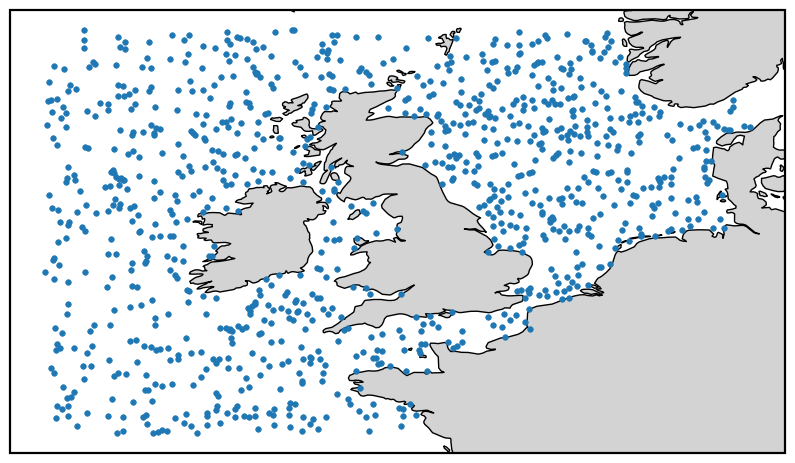

In [ ]:

pt = 'inertial'
dt_write = timedelta(seconds=10).seconds
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
ax.coastlines()
ax.add_feature(cart.feature.LAND, facecolor='lightgrey')
ax.plot(data_short[pt][dt_write].lon[:,0],data_short[pt][dt_write].lat[:,0],'.')